In [1]:
import h5py
import os
import seaborn as sns
import joblib
import copy
import cv2
import glob
import numpy as np
from tqdm import tqdm
from PIL import Image
from collections import OrderedDict

import habitat
from habitat.utils.visualizations import maps, utils

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

In [2]:
ACTUAL_ROUTE_COLOR = [0, 0, 200]  # Blue
VO_ROUTE_COLOR = (200, 0, 0)   # red

In [61]:
!ls /datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_det-rnd_n_10-20221118_185336087193/videos

 Cantwell
 Denmark
 Eastville
'episode=0-ckpt=0-distance_to_goal=0.15-success=1.00-spl=0.79-softspl=0.77-collisions.count=10.00.mp4'
'episode=0-ckpt=0-distance_to_goal=0.19-success=1.00-spl=0.82-softspl=0.80-collisions.count=3.00.mp4'
'episode=0-ckpt=0-distance_to_goal=0.57-success=0.00-spl=0.00-softspl=0.72-collisions.count=28.00.mp4'
'episode=10-ckpt=0-distance_to_goal=0.06-success=1.00-spl=0.87-softspl=0.86-collisions.count=1.00.mp4'
'episode=10-ckpt=0-distance_to_goal=0.14-success=1.00-spl=0.91-softspl=0.86-collisions.count=0.00.mp4'
'episode=10-ckpt=0-distance_to_goal=0.17-success=1.00-spl=0.79-softspl=0.77-collisions.count=1.00.mp4'
'episode=11-ckpt=0-distance_to_goal=0.08-success=1.00-spl=0.84-softspl=0.83-collisions.count=0.00.mp4'
'episode=11-ckpt=0-distance_to_goal=0.09-success=1.00-spl=0.80-softspl=0.78-collisions.count=1.00.mp4'
'episode=11-ckpt=0-distance_to_goal=0.20-success=1.00-spl=0.90-softspl=0.85-collisions.count=0.00.mp4'
'episode=12-ckpt=0-distance_to_goal=0.06-suc

In [2]:
!ls /datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_icp-rnd_n_10-20230127_211211232870/infos

eval_infos.p  rl_no_tune.infos.p


Scenes: **'Cantwell.glb'**, 'Denmark.glb', 'Eastville.glb

Assume the evaluation results are saved under `$SAVE_DIR`. Please assign `info_f` to the `$SAVE_DIR/infos/XX.infos.p`.

In [37]:
# MMAE
SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_det-rnd_n_10-20221108_185532202372/infos"
info_f = f"{SAVE_DIR}/XX.infos.p"
# info_f = f"{SAVE_DIR}/train_objective_info.p"
info_dict_rgbd = joblib.load(open(info_f, "rb"))

SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_det-rnd_n_10-20221108_183138562393/infos"
info_f = f"{SAVE_DIR}/XX.infos.p"
# info_f = f"{SAVE_DIR}/train_objective_info.p"
info_dict_srgb = joblib.load(open(info_f, "rb"))

SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_det-rnd_n_10-20221108_184444870956/infos"
info_f = f"{SAVE_DIR}/XX.infos.p"
# info_f = f"{SAVE_DIR}/train_objective_info.p"
info_dict_sd = joblib.load(open(info_f, "rb"))

In [4]:
# # MMAE
# SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_det-rnd_n_10-20221118_185336087193/infos"
# info_f = f"{SAVE_DIR}/XX.infos.p"
# # info_f = f"{SAVE_DIR}/train_objective_info.p"
# info_dict_rgbd = joblib.load(open(info_f, "rb"))

# SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_det-rnd_n_10-20221118_185505258427/infos"
# info_f = f"{SAVE_DIR}/XX.infos.p"
# # info_f = f"{SAVE_DIR}/train_objective_info.p"
# info_dict_srgb = joblib.load(open(info_f, "rb"))

# SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_det-rnd_n_10-20221118_185508243411/infos"
# info_f = f"{SAVE_DIR}/XX.infos.p"
# # info_f = f"{SAVE_DIR}/train_objective_info.p"
# info_dict_sd = joblib.load(open(info_f, "rb"))

In [38]:
# MMAE w/ inv

SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_det-rnd_n_10-20221108_182708527530/infos"
info_f = f"{SAVE_DIR}/XX.infos.p"
# info_f = f"{SAVE_DIR}/train_objective_info.p"
info_dict_rgbd_inv = joblib.load(open(info_f, "rb"))

SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_det-rnd_n_10-20221108_183545402171/infos"
info_f = f"{SAVE_DIR}/XX.infos.p"
# info_f = f"{SAVE_DIR}/train_objective_info.p"
info_dict_srgb_inv = joblib.load(open(info_f, "rb"))

SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_det-rnd_n_10-20221108_211528210000/infos"
info_f = f"{SAVE_DIR}/XX.infos.p"
# info_f = f"{SAVE_DIR}/train_objective_info.p"
info_dict_sd_inv = joblib.load(open(info_f, "rb"))

In [5]:
# # MMAE w/ inv

# SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_det-rnd_n_10-20221118_185338266304/infos"
# info_f = f"{SAVE_DIR}/XX.infos.p"
# # info_f = f"{SAVE_DIR}/train_objective_info.p"
# info_dict_rgbd_inv = joblib.load(open(info_f, "rb"))

# SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_det-rnd_n_10-20221118_185423674352/infos"
# info_f = f"{SAVE_DIR}/XX.infos.p"
# # info_f = f"{SAVE_DIR}/train_objective_info.p"
# info_dict_srgb_inv = joblib.load(open(info_f, "rb"))

# SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_det-rnd_n_10-20221118_185346000918/infos"
# info_f = f"{SAVE_DIR}/XX.infos.p"
# # info_f = f"{SAVE_DIR}/train_objective_info.p"
# info_dict_sd_inv = joblib.load(open(info_f, "rb"))

EOFError: Compressed file ended before the end-of-stream marker was reached

In [69]:
SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_det-rnd_n_10-20221118_185346000918/infos"
info_f = f"{SAVE_DIR}/XX.infos.p"
# info_f = f"{SAVE_DIR}/train_objective_info.p"
info_dict_sd_inv = joblib.load(open(info_f, "rb"))

EOFError: Compressed file ended before the end-of-stream marker was reached

In [3]:
SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_icp-rnd_n_10-20230130_232641554359/infos"
info_f = f"{SAVE_DIR}/XX.infos.p"
info_dict_icp = joblib.load(open(info_f, "rb"))

In [3]:
def _get_map_coord(map_info, step_info, state_k):

    map_agent_x, map_agent_y = maps.to_grid(
        step_info[f"{state_k}"]["position"][0], # x
        step_info[f"{state_k}"]["position"][2], # z
        map_info["coordinate_min"],
        map_info["coordinate_max"],
        map_info["map_resolution"],
    )
    agent_map_coord = (
        map_agent_x - (map_info["ind_x_min"] - map_info["grid_delta"]),
        map_agent_y - (map_info["ind_y_min"] - map_info["grid_delta"]),
    )
    
    return agent_map_coord

In [4]:
def draw_traj_top_down_map(traj_info, title='', file=''):
    
    N = 20
    
    print("S", traj_info["stat"]["success"], "SPL", traj_info["stat"]["spl"], "SSPL", traj_info["stat"]["softspl"])
    
    map_info = traj_info["map"]
    top_down_map = map_info["blank_top_down_map"]
    top_down_map = maps.colorize_topdown_map(top_down_map)
    
    # print(top_down_map.shape)
    
    step_infos = traj_info["traj"]
    # print(len(step_infos))
    
    actual_map_coords = []
    imagine_map_coords = []
        
    for elem in step_infos:
        actual_map_coords.append(
            _get_map_coord(map_info, elem, "cur_agent_state")
        )
        imagine_map_coords.append(
            _get_map_coord(map_info, elem, "cur_agent_state_from_vo")
        )
        
    line_thickness = int( max(1, int(top_down_map.shape[0] / 40)) * 1 ) // 4
    agent_size = int(top_down_map.shape[0] / 30) * 1
    # print(line_thickness)
        
    # actual path
    maps.draw_path(
        top_down_map,
        actual_map_coords,
        ACTUAL_ROUTE_COLOR,
        line_thickness
    )
    
    # VO imagine path
    maps.draw_path(
        top_down_map,
        imagine_map_coords,
        VO_ROUTE_COLOR,
        line_thickness
    )
    
    # blue
    source_square = np.zeros((agent_size * 2, agent_size * 2, 3))
    source_square[:, :, 2] = 255
    source_map_coord = _get_map_coord(map_info, {"placeholder": traj_info["start"]}, "placeholder")
    
    utils.paste_overlapping_image(top_down_map, source_square, source_map_coord)
    
    # green
    goal_square = np.zeros((agent_size * 2, agent_size * 2, 3))
    goal_square[:, :, 1] = 255
    goal_map_coord = _get_map_coord(map_info, {"placeholder": traj_info["goal"]}, "placeholder")
    
    utils.paste_overlapping_image(top_down_map, goal_square, goal_map_coord)
    
    # draw agent's position
    top_down_map = maps.draw_agent(
        top_down_map,
        actual_map_coords[-1],
        # heading - np.pi / 2,
        step_infos[-1][f"cur_agent_angle"],
        agent_radius_px=agent_size,
    )
    
    if top_down_map.shape[0] > top_down_map.shape[1]:
        # top_down_map = np.transpose(top_down_map, (1, 0, 2))
        top_down_map = np.rot90(top_down_map, 1)
    
    # print(top_down_map.shape)
    
    top_down_map_img = Image.fromarray(top_down_map)
    plt.imshow(top_down_map_img)
#     plt.title(title)
    plt.axis('off')
    top_down_map_img.save(f"./{file}.pdf")

In [5]:
def draw_traj_top_down_map_multi(traj_info_rgbd, traj_info_srgb, traj_info_sd, title='', file=''):
    
    N = 20
    
    ACTUAL_ROUTE_COLOR = [ [255, 255, 0], [255, 0, 0], [128, 0, 255] ]  # Blue
    VO_ROUTE_COLOR = [ [0, 255, 190], [255, 190, 0], [190, 0, 255] ]  # red

    print("S", traj_info_rgbd["stat"]["success"], traj_info_sd["stat"]["success"], traj_info_srgb["stat"]["success"])
    
    map_info = traj_info_rgbd["map"]
    top_down_map = map_info["blank_top_down_map"]
    top_down_map = maps.colorize_topdown_map(top_down_map)
    
    # print(top_down_map.shape)
    
    for i, traj_info in enumerate([traj_info_rgbd, traj_info_srgb, traj_info_sd]):
        
        step_infos = traj_info["traj"]
        # print(len(step_infos))

        actual_map_coords = []
        imagine_map_coords = []

        for elem in step_infos:
            actual_map_coords.append(
                _get_map_coord(map_info, elem, "cur_agent_state")
            )
            imagine_map_coords.append(
                _get_map_coord(map_info, elem, "cur_agent_state_from_vo")
            )

        line_thickness = int( max(1, int(top_down_map.shape[0] / 40)) * 1 ) // 4
        agent_size = int(top_down_map.shape[0] / 30) * 1
        # print(line_thickness)

        # actual path
        maps.draw_path(
            top_down_map,
            actual_map_coords,
            ACTUAL_ROUTE_COLOR[i],
            line_thickness
        )

#         # VO imagine path
#         maps.draw_path(
#             top_down_map,
#             imagine_map_coords,
#             VO_ROUTE_COLOR[i],
#             line_thickness
#         )
    
    # blue
    source_square = np.zeros((agent_size * 2, agent_size * 2, 3))
    source_square[:, :, 2] = 255
    source_map_coord = _get_map_coord(map_info, {"placeholder": traj_info["start"]}, "placeholder")
    
    utils.paste_overlapping_image(top_down_map, source_square, source_map_coord)
    
    # green
    goal_square = np.zeros((agent_size * 2, agent_size * 2, 3))
    goal_square[:, :, 1] = 255
    goal_map_coord = _get_map_coord(map_info, {"placeholder": traj_info["goal"]}, "placeholder")
    
    utils.paste_overlapping_image(top_down_map, goal_square, goal_map_coord)
    
    # draw agent's position
#     top_down_map = maps.draw_agent(
#         top_down_map,
#         actual_map_coords[-1],
#         # heading - np.pi / 2,
#         step_infos[-1][f"cur_agent_angle"],
#         agent_radius_px=agent_size,
#     )
    
    if top_down_map.shape[0] > top_down_map.shape[1]:
        # top_down_map = np.transpose(top_down_map, (1, 0, 2))
        top_down_map = np.rot90(top_down_map, 1)
    
    # print(top_down_map.shape)
    
    top_down_map_img = Image.fromarray(top_down_map)
    plt.imshow(top_down_map_img)
#     plt.title(title)
    plt.axis('off')
    top_down_map_img.save(f"./{file}.pdf")

S 0.0 SPL 0.0 SSPL 0.3803024753366369


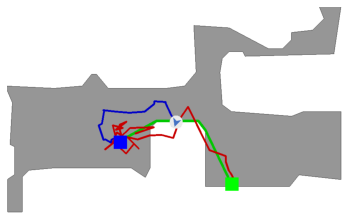

In [7]:
# fwd, 2+, 3-, arccos
SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_icp-rnd_n_10-20230131_020600609630/infos"
info_f = f"{SAVE_DIR}/XX.infos.p"
info_dict_icp = joblib.load(open(info_f, "rb"))
draw_traj_top_down_map(info_dict_icp[0], file=f"mmae_drop_rgb_{0}")

S 0.0 SPL 0.0 SSPL 0.0


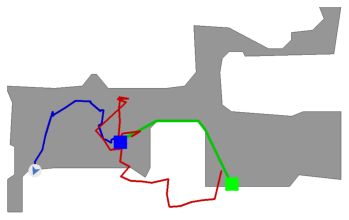

In [8]:
# 1e+4 fwd, 2+, 3-, arccos
SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_icp-rnd_n_10-20230130_232641554359/infos"
info_f = f"{SAVE_DIR}/XX.infos.p"
info_dict_icp = joblib.load(open(info_f, "rb"))
draw_traj_top_down_map(info_dict_icp[0], file=f"mmae_drop_rgb_{0}")

S 0.0 0.0 0.0


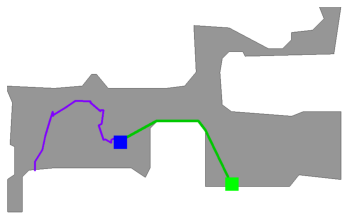

In [11]:
traj_idx=0
draw_traj_top_down_map_multi(info_dict_icp[traj_idx], info_dict_icp[traj_idx], info_dict_icp[traj_idx], " ", file=f"mmae_drop_all_inv_{traj_idx}")

In [7]:
traj_idx = 22
draw_traj_top_down_map_multi(info_dict_rgbd[traj_idx], info_dict_srgb[traj_idx], info_dict_sd[traj_idx], " ", file=f"mmae_drop_all_{traj_idx}")

NameError: name 'info_dict_rgbd' is not defined

In [6]:
# 1e+4 fwd, 2+, 3-, arccos
SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_icp-rnd_n_10-20230130_232641554359/infos"
info_f = f"{SAVE_DIR}/XX.infos.p"
info_dict_icp = joblib.load(open(info_f, "rb"))

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [7]:
# fwd, 2+, 3-, arccos
SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_icp-rnd_n_10-20230131_004425610128/infos"
info_f = f"{SAVE_DIR}/XX.infos.p"
info_dict_icp = joblib.load(open(info_f, "rb"))

FileNotFoundError: [Errno 2] No such file or directory: '/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_icp-rnd_n_10-20230131_004425610128/infos/XX.infos.p'

In [ ]:
draw_traj_top_down_map(info_dict_icp[traj_idx], file=f"mmae_drop_rgb_{traj_idx}")

S 0.0 SPL 0.0 SSPL 0.0


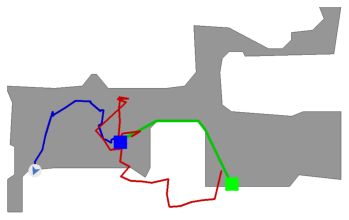

In [12]:
draw_traj_top_down_map(info_dict_icp[traj_idx], file=f"mmae_drop_rgb_{traj_idx}")

S 1.0 SPL 0.8377907128418756 SSPL 0.8247232798913071


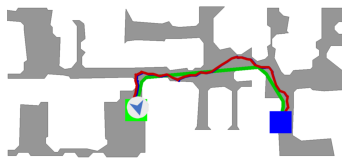

In [90]:
draw_traj_top_down_map(info_dict_rgbd[traj_idx], file=f"mmae_drop_none_{traj_idx}")

S 1.0 SPL 0.8208145404820426 SSPL 0.804294151574118


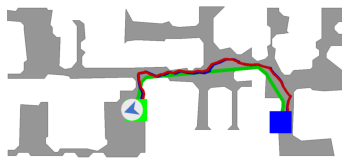

In [91]:
draw_traj_top_down_map(info_dict_srgb[traj_idx], file=f"mmae_drop_rgb_{traj_idx}")

S 0.0 SPL 0.0 SSPL 0.6983791952316739


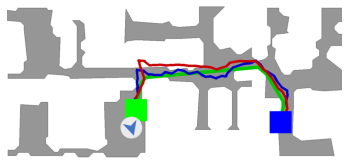

In [92]:
draw_traj_top_down_map(info_dict_sd[traj_idx], file=f"mmae_drop_d_{traj_idx}")

S 1.0 SPL 0.8218936313885968 SSPL 0.8065318426953301


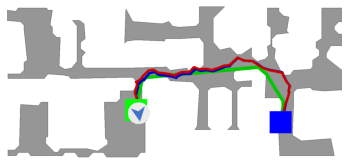

In [93]:
draw_traj_top_down_map(info_dict_rgbd_inv[traj_idx], file=f"mmae_drop_none_inv_{traj_idx}")

S 1.0 SPL 0.8437411806313254 SSPL 0.8306483420997872


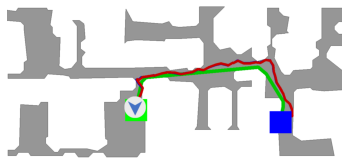

In [94]:
draw_traj_top_down_map(info_dict_srgb_inv[traj_idx], file=f"mmae_drop_rgb_inv_{traj_idx}")

S 0.0 SPL 0.0 SSPL 0.8198098924622244


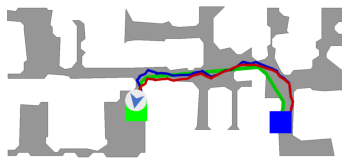

In [95]:
draw_traj_top_down_map(info_dict_sd_inv[traj_idx], file=f"mmae_drop_d_inv_{traj_idx}")

S 0.0 SPL 0.0 SSPL 0.7236287937716389


(-0.5, 1249.5, 564.5, -0.5)

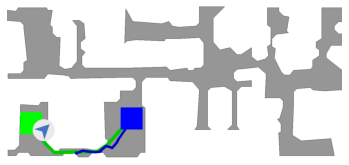

In [76]:
traj_info = info_dict_sd_inv[traj_idx]

N = 20

print("S", traj_info["stat"]["success"], "SPL", traj_info["stat"]["spl"], "SSPL", traj_info["stat"]["softspl"])

map_info = traj_info["map"]
top_down_map = map_info["blank_top_down_map"]
top_down_map = maps.colorize_topdown_map(top_down_map)

# print(top_down_map.shape)

step_infos = traj_info["traj"]
# print(len(step_infos))

actual_map_coords = []
imagine_map_coords = []

for elem in step_infos:
    actual_map_coords.append(
        _get_map_coord(map_info, elem, "cur_agent_state")
    )
    imagine_map_coords.append(
        _get_map_coord(map_info, elem, "cur_agent_state_from_vo")
    )
    
line_thickness = int( max(1, int(top_down_map.shape[0] / 40)) * 1 ) // 4
agent_size = int(top_down_map.shape[0] / 30) * 1
# print(line_thickness)

# actual path
maps.draw_path(
    top_down_map,
    actual_map_coords[:35],
    ACTUAL_ROUTE_COLOR,
    line_thickness
)

# # VO imagine path
# maps.draw_path(
#     top_down_map,
#     imagine_map_coords,
#     VO_ROUTE_COLOR,
#     line_thickness
# )

# blue
source_square = np.zeros((agent_size * 2, agent_size * 2, 3))
source_square[:, :, 2] = 255
source_map_coord = _get_map_coord(map_info, {"placeholder": traj_info["start"]}, "placeholder")

utils.paste_overlapping_image(top_down_map, source_square, source_map_coord)

# green
goal_square = np.zeros((agent_size * 2, agent_size * 2, 3))
goal_square[:, :, 1] = 255
goal_map_coord = _get_map_coord(map_info, {"placeholder": traj_info["goal"]}, "placeholder")

utils.paste_overlapping_image(top_down_map, goal_square, goal_map_coord)

# draw agent's position
top_down_map = maps.draw_agent(
    top_down_map,
    actual_map_coords[-1],
    # heading - np.pi / 2,
    step_infos[-1][f"cur_agent_angle"],
    agent_radius_px=agent_size,
)

if top_down_map.shape[0] > top_down_map.shape[1]:
    # top_down_map = np.transpose(top_down_map, (1, 0, 2))
    top_down_map = np.rot90(top_down_map, 1)

# print(top_down_map.shape)

top_down_map_img = Image.fromarray(top_down_map)
plt.imshow(top_down_map_img)
#     plt.title(title)
plt.axis('off')
# top_down_map_img.save(f"./{file}.pdf")

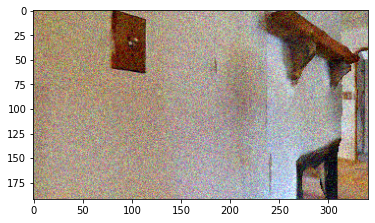

In [278]:
idx = 41
plt.imshow(traj_info['traj'][idx]["rgb"])
plt.show()

In [4]:
# MMAE
SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_det-rnd_n_10-20221108_185532202372/infos"
info_f = f"{SAVE_DIR}/XX.infos.p"
# info_f = f"{SAVE_DIR}/train_objective_info.p"
info_dict_rgbd = joblib.load(open(info_f, "rb"))

In [8]:
d = info_dict_rgbd[0]["traj"][0]

In [9]:
def min_angle_between_quaternions(q1, q2, in_degrees=True):
    min_angle = 2 * np.arccos((q1.conj() * q2).w)
    return np.rad2deg(min_angle) if in_degrees else min_angle

def dist_between_points(p1, p2):
    return np.linalg.norm(p1 - p2)


cur_rot = d['cur_agent_state']['rotation']
prev_rot = d['prev_agent_state']['rotation']
cur_rot_vo = d['cur_agent_state_from_vo']['rotation']
prev_rot_vo = d['prev_agent_state_from_vo']['rotation']

rot = min_angle_between_quaternions(cur_rot, prev_rot)
rot_vo = min_angle_between_quaternions(cur_rot_vo, prev_rot_vo)

In [10]:
rot, rot_vo

(20.11878803346653, 20.077021753908884)